In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark")  

In [2]:
# get the champagne sales data 

!wget -nc https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv

--2024-04-16 18:22:39--  https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1598 (1.6K) [text/csv]
Saving to: 'perrin-freres-monthly-champagne.csv'

perrin-freres-month 100%[===================>]   1.56K  --.-KB/s    in 0s      

2024-04-16 18:22:40 (13.9 MB/s) - 'perrin-freres-monthly-champagne.csv' saved [1598/1598]



In [61]:
df = pd.read_csv('perrin-freres-monthly-champagne.csv', parse_dates= True)

df.tail()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [62]:
df.isna().sum()

Month                                                     1
Perrin Freres monthly champagne sales millions ?64-?72    2
dtype: int64

In [63]:
df.dropna(inplace=True)

df.set_index('Month', inplace = True)

df.columns = ['Sales']

df.head()

,Sales
Month,
1964-01,2815.0
1964-02,2672.0
1964-03,2755.0
1964-04,2721.0
1964-05,2946.0


In [64]:
df['LogSales'] = np.log(df['Sales'])

df.head()

,Sales,LogSales
Month,,
1964-01,2815.0,7.942718
1964-02,2672.0,7.890583
1964-03,2755.0,7.921173
1964-04,2721.0,7.908755
1964-05,2946.0,7.988204


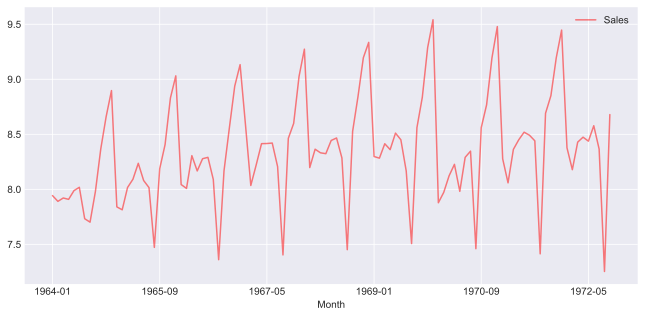

In [65]:
fig, axes = plt.subplots(figsize = (11,5))

df['LogSales'].plot(ax = axes, color = 'red', alpha = 0.5, label = 'Sales')


axes.legend()
axes.grid()



Seasonal patterns exist with some anomalies! 

In [66]:
# We will work with differenced log sales series, first split the whole data 

Ntest = 12
train, test = df[:-Ntest], df[-Ntest:]

In [67]:
# We will prepare data suitable to use previous 12 values in the series to predict the next

series = df['LogSales'].to_numpy() 

T = 12

X = list()
Y =list()

for t in range(len(series)-T): # -T because there is no sliding window of 12 after a certain index towards the end of the series

    x = series[t:t+T] # take 0th to 11th, 1th to 12th, ... indexed values as the X 
    X.append(x)

    y = series[t+T] # set the 12th, 13th, ... as the corresponding target 
    Y.append(y)

X = np.array(X)
y = np.array(Y)
N = len(X) # number of observations

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (93, 12), y shape: (93,)


In [68]:
X_train, y_train = X[:-Ntest], y[:-Ntest]
X_test, y_test = X[-Ntest:], y[-Ntest:]

X_train.shape

(81, 12)

In [69]:
# Boolean indexing according to train test split 

train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T] = False # first T values are not predictable 

In [55]:
test_LSales = df.iloc[-Ntest:]['LogSales'] # test log sales required to compute test rmse for mstep fcast

In [70]:
# define a helper function that performs one and multi-step forecast 

def onesd_and_msd_fcast(model, name): 

    model.fit(X_train, y_train)
    print(f"One-step forecast for {name}:")

    # store one-step forecast to df
    df.loc[train_idx, f"{name}_1s_train"] =  model.predict(X_train)
    df.loc[test_idx, f"{name}_1s_test"] = model.predict(X_test)

    #RMSE of one-step forecast 
    rmse_1s = mean_squared_error(y_test, df.loc[test_idx, f"{name}_1s_test"], squared = False)
    print(f'Test RMSE for one-step: {rmse_1s:.3f}')

    # generate incremental multi-step forecast

    ms_preds = list()

    # first test input 
    last_x = X_test[0]

    while len(ms_preds) < Ntest:

        # get the first prediction
        pred = model.predict(last_x.reshape(1,-1))[0]

        ms_preds.append(pred)

        # update the test series by assigning the last prediction 

        last_x = np.roll(last_x, -1)
        last_x[-1] = pred

    # store the multi-step test forecast 
    df.loc[test_idx, f"{name}_ms_test"] = ms_preds

    print(f"Multi-step forecast for {name}:")
    #RMSE of multi-step forecast 
    rmse_ms = mean_squared_error(test_LSales, df.loc[test_idx, f"{name}_ms_test"], squared = False)
    print(f'Test RMSE for multi-step: {rmse_ms:.3f}')

    # plot the predictions together 

    fig, axes = plt.subplots(figsize = (11,5))
    plot_cols = ['LogSales', f"{name}_1s_train", f"{name}_1s_test", f"{name}_ms_test"]

    df[plot_cols].plot(ax= axes)

    axes.grid()

One-step forecast for LR:
Test RMSE for one-step: 0.096
Multi-step forecast for LR:
Test RMSE for multi-step: 0.092


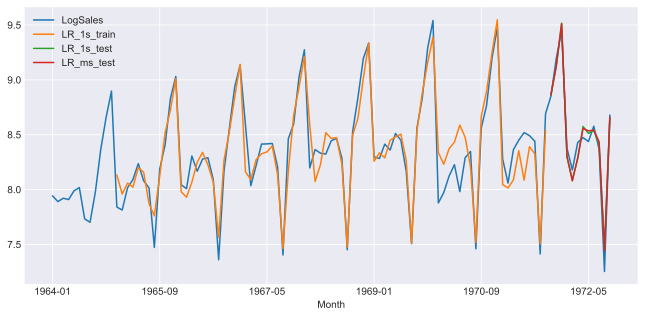

In [71]:
onesd_and_msd_fcast(LinearRegression(),'LR')

One-step forecast for SVR:
Test RMSE for one-step: 0.145
Multi-step forecast for SVR:
Test RMSE for multi-step: 0.134


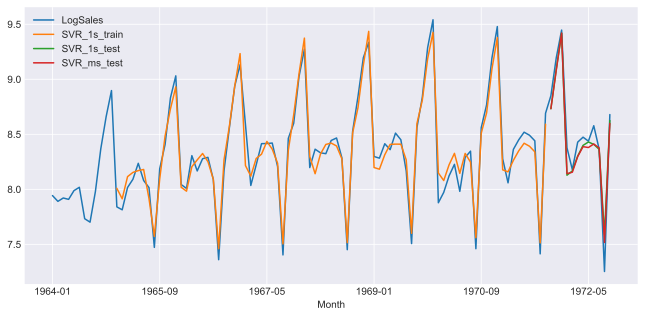

In [72]:
onesd_and_msd_fcast(SVR(),'SVR')

One-step forecast for RFR:
Test RMSE for one-step: 0.107
Multi-step forecast for RFR:
Test RMSE for multi-step: 0.106


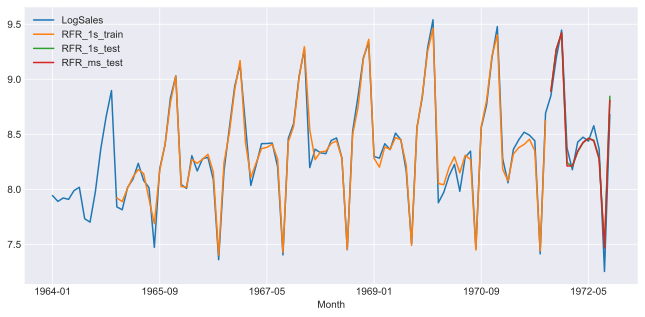

In [73]:
onesd_and_msd_fcast(RandomForestRegressor(),'RFR')

In [74]:
# prepare multi-output supervised dataset 
# we will use past T values to predict next Ty values

Tx = T # T = 12
Ty = Ntest # given past 12 values predict the next 12

Xm = list()
Ym =list()

for t in range(len(series)-Tx-Ty+1): # -Tx-Ty because there is no sliding window of 10 X values with the corresponding 12 y labels

    x = series[t:t+Tx] # take 0th to 9th, 1th to 10th, ... indexed val as the X 
    Xm.append(x)

    y = series[t+Tx:t+Tx+Ty] # set the 10th, 11th, ... as the corresponding target 
    Ym.append(y)

Xm = np.array(Xm)
ym = np.array(Ym)
N = len(Xm) # number of observations

print(f"X shape: {Xm.shape}, y shape: {ym.shape}")

X shape: (82, 12), y shape: (82, 12)


In [75]:
# train-test split 

X_train_m, y_train_m = Xm[:-1], ym[:-1] # all but the last values are training since we would like to forecast for the final Ntest = 12 values 

X_test_m, y_test_m = Xm[-1:], ym[-1:]

print(f"X_test shape: {X_test_m.shape}, y_test shape: {y_test_m.shape}")

X_test shape: (1, 12), y_test shape: (1, 12)


In [76]:
# define another helper function for multi_output forecasting 

def mo_fcast(model, name):

    model.fit(X_train_m, y_train_m)

    # save the predictions to df 

    df.loc[test_idx, f'{name}_mo_test'] = model.predict(X_test_m).flatten()

    print(f'Multi-output forecast for {name}')
    
    # rmse 
    rmse = mean_squared_error(y_test, df.loc[test_idx, f'{name}_mo_test'], squared = False)
    print(f'Test RMSE for multi-output {name}: {rmse:.3f}')

    # plot 

    fig, axes = plt.subplots(figsize = (11,5))
    plot_cols = ['LogSales', f"{name}_1s_train", f"{name}_1s_test", f"{name}_ms_test", f"{name}_mo_test"]

    df[plot_cols].plot(ax= axes)

    axes.grid()

Multi-output forecast for LR
Test RMSE for multi-output LR: 0.100


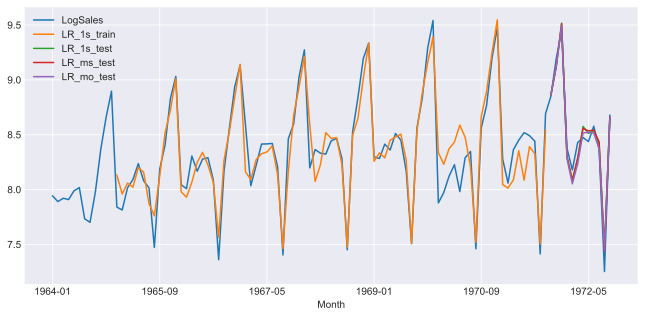

In [77]:
mo_fcast(LinearRegression(), 'LR')

Multi-output forecast for RFR
Test RMSE for multi-output RFR: 0.194


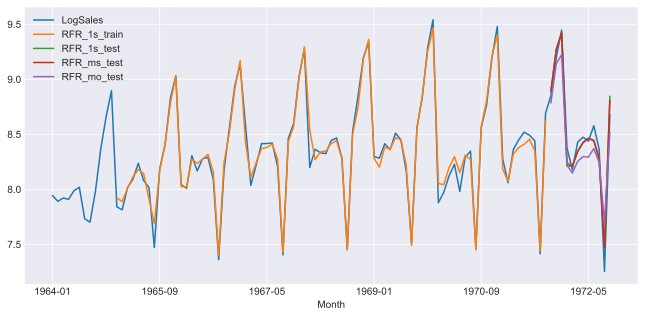

In [79]:
mo_fcast(RandomForestRegressor(), 'RFR')